# 第4章: 形態素解析

夏目漱石の小説『吾輩は猫である』の文章（neko.txt）をMeCabを使って形態素解析し，その結果をneko.txt.mecabというファイルに保存せよ．このファイルを用いて，以下の問に対応するプログラムを実装せよ．

なお，問題37, 38, 39はmatplotlibもしくはGnuplotを用いるとよい．
```bash
$ brew install mecab 
$ brew install mecab-ipadic
$ brew install git curl xz
$ git clone --depth 1 git@github.com:neologd/mecab-ipadic-neologd.git
$ cd mecab-ipadic-neologd
$ ./bin/install-mecab-ipadic-neologd -n
$ brew install swig
$ pip install mecab-python3 
$ mecab ../input/neko.txt -o ../output/neko.txt.mecab
```
### mecabの形態素解析のテンプレート
```
表層形\t品詞,品詞細分類1,品詞細分類2,品詞細分類3,活用型,活用形,原形,読み,発音
```

# 30. 形態素解析結果の読み込み
形態素解析結果（neko.txt.mecab）を読み込むプログラムを実装せよ．ただし，各形態素は表層形（surface），基本形（base），品詞（pos），品詞細分類1（pos1）をキーとするマッピング型に格納し，1文を形態素（マッピング型）のリストとして表現せよ．第4章の残りの問題では，ここで作ったプログラムを活用せよ．

In [1]:
import re
import csv

whole_text = []
sent = []
set_surface = set()
set_base = set()

with open("../output/neko.txt.mecab", mode="r") as mecab_morph:
    for morph in mecab_morph:
        if "EOS" in morph:
            whole_text.append(sent)
            sent = []
            continue
        items = re.split("[\t,]", morph.rstrip())
        if len(items) != 10:
            continue
        surface, pos, pos_1, _, _, _, _, base, _, _ \
            = (item for item in items)
        morph_dict = dict()
        if surface: 
            morph_dict["surface"] = surface
            if pos == "動詞":
                set_surface.add(surface)
        if base: 
            morph_dict["base"] = base
            if pos == "動詞":
                set_base.add(base)
        if pos: 
            morph_dict["pos"] = pos
        if pos_1: 
            morph_dict["pos1"] = pos_1
        sent.append(morph_dict)

# 31. 動詞
動詞の表層形をすべて抽出せよ．

In [2]:
with open("../output/neko.txt.extract_base", mode="w") as f_base:
    writer = csv.writer(f_base)
    writer.writerow(list(set_base))

# 32. 動詞の基本形
動詞の基本形をすべて抽出せよ．

In [3]:
with open("../output/neko.txt.extract_surface", mode="w") as f_surface:
    writer = csv.writer(f_surface)
    writer.writerow(list(set_surface))

# 33. 「AのB」
2つの名詞が「の」で連結されている名詞句を抽出せよ．

In [4]:
A_of_B = []
for sent in whole_text:
    l = len(sent)
    for i, word in enumerate(sent):
        if word["surface"] == "の" and 1 <= i < l - 1:
            if sent[i-1]["pos"] == "名詞" and sent[i+1]["pos"] == "名詞":
                A_of_B.append(sent[i-1]["surface"] + "の" + sent[i+1]["surface"])

with open("../output/neko.txt.extract_A_of_B", mode="w") as f_AofB:
    writer = csv.writer(f_AofB)
    writer.writerow(A_of_B)

# 34. 名詞の連接
名詞の連接（連続して出現する名詞）を最長一致で抽出せよ．

In [5]:
series_nouns = []
nouns = []
for sent in whole_text:
    l = len(sent)
    for i, word in enumerate(sent):
        if word["pos"] == "名詞":
            nouns.append(word["surface"])
            if (i == l - 1) and (len(nouns) > 1):
                series_nouns.append("".join(nouns))
        else:
            if len(nouns) > 1:
                series_nouns.append("".join(nouns))
            nouns = []
            

with open("../output/neko.txt.series_nouns", mode="w") as f_series:
    writer = csv.writer(f_series)
    writer.writerow(series_nouns)

# 35. 単語の出現頻度
文章中に出現する単語とその出現頻度を求め，出現頻度の高い順に並べよ．

# 36. 頻度上位10語
出現頻度が高い10語とその出現頻度をグラフ（例えば棒グラフなど）で表示せよ．

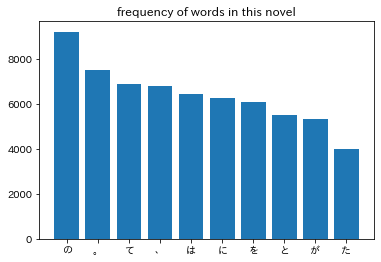

In [7]:
from collections import Counter
%matplotlib inline
import matplotlib.pyplot as plt
all_words = [word["surface"] for sent in whole_text for word in sent]
counter = Counter(all_words)
x, y = map(list, zip(*counter.most_common(10)))

plt.bar(x, y)
plt.title("frequency of words in this novel")
plt.show()

# 37. 「猫」と共起頻度の高い上位10語
「猫」とよく共起する（共起頻度が高い）10語とその出現頻度をグラフ（例えば棒グラフなど）で表示せよ．

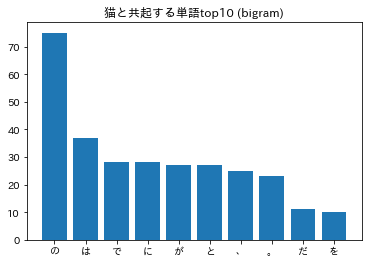

In [16]:
def make_ngram(n: int, s):
    li = []
    for i in range(len(s) - n + 1):
        li.append(s[i:i+n])
    return li

word_counter = dict()
word_bi_gram = make_ngram(2, all_words)
for a, b in word_bi_gram:
    if a == "猫":
        if b in word_counter:
            word_counter[b] += 1
        else:
            word_counter[b] = 1
    elif b == "猫":
        if a in word_counter:
            word_counter[a] += 1
        else:
            word_counter[a] = 1
most_commons = sorted(word_counter.items(), key=lambda x: x[1], reverse=True)[:10]
x, y = map(list, zip(*most_commons))
plt.bar(x, y)
plt.title("猫と共起する単語top10 (bigram)")
plt.show()

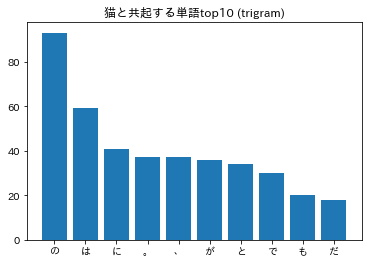

In [18]:
word_counter = dict()
word_tri_gram = make_ngram(3, all_words)
for a, b, c in word_tri_gram:
    if a == "猫":
        if b in word_counter:
            word_counter[b] += 1
        else:
            word_counter[b] = 1
        if c in word_counter:
            word_counter[c] += 1
        else:
            word_counter[c] = 1
    elif c == "猫":
        if a in word_counter:
            word_counter[a] += 1
        else:
            word_counter[a] = 1
        if b in word_counter:
            word_counter[b] += 1
        else:
            word_counter[b] = 1
most_commons = sorted(word_counter.items(), key=lambda x: x[1], reverse=True)[:10]
x, y = map(list, zip(*most_commons))
plt.bar(x, y)
plt.title("猫と共起する単語top10 (trigram)")
plt.show()

# 38. ヒストグラム
単語の出現頻度のヒストグラムを描け．ただし，横軸は出現頻度を表し，1から単語の出現頻度の最大値までの線形目盛とする．縦軸はx軸で示される出現頻度となった単語の異なり数（種類数）である．

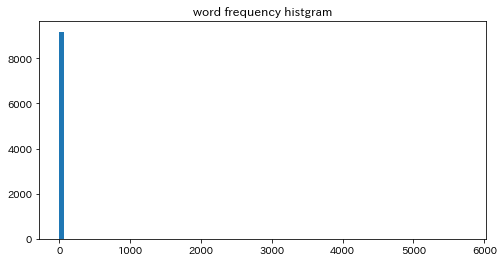

In [41]:
freq_counter = {i: 0 for i in range(1, counter.most_common(1)[0][1] + 1)}
for k, v in counter.most_common():
    freq_counter[v] += 1
#freq_counter_sorted = sorted(freq_counter.items())
#x, y = map(list, zip(*freq_counter_sorted))
plt.figure(figsize=(8, 4))
plt.hist(freq_counter.values(), bins=100)
plt.title("word frequency histgram")
plt.show()

# 39. Zipfの法則
単語の出現頻度順位を横軸，その出現頻度を縦軸として，両対数グラフをプロットせよ．

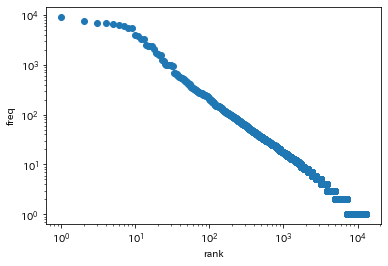

In [42]:
x, y = map(list, zip(*counter.most_common()))
x = [i for i in range(1, len(x) + 1)]
plt.scatter(x, y)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('rank')
plt.ylabel('freq')
plt.show()